# 装包和导入

In [1]:
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/drive/MyDrive
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

# The folder with the data and this script should be saved in your drive.
script_name = 'CourseWork_v2.ipynb'
script_path = find(script_name, '/content/gdrive/My Drive')
#DIRECTORY = '.'#os.path.dirname(script_path)
# If your Drive is too large and the "find" function takes to much time, you can set the directory manually :

#SUMMARY_PATH = '/content/drive/MyDrive/MutualFundSummary'
#SUMMARY_LABELS_PATH = '/content/drive/MyDrive/MutualFundLabels.csv'

DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

#导入数据，划分训练集和测试集

In [3]:
# read data
#labels = pd.read_csv('/content/MutualFundLabels.csv')
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundLabels.csv')
labels = labels.drop('Performance fee?', axis=1)

removes = labels.loc[(labels['Ivestment Strategy']=='Long Short Funds (High Risk)')|
                     (labels['Ivestment Strategy']=='Commodities Fund (Low Risk)')]
labels_clean = labels.drop(removes.index)

fund_names, summaries = get_data(SUMMARY_PATH)
cleaned_fund_names = labels_clean['fund_name'].tolist()

# Create a dictionary to store the summaries without labels
unlabeled_summaries = {}

for name, summary in zip(fund_names, summaries):
    if name not in cleaned_fund_names:
        unlabeled_summaries[name] = summary

# Create a DataFrame with the unlabeled summaries
df_unlabeled_summaries = pd.DataFrame(data={'fund_name': list(unlabeled_summaries.keys()),
                                            'summary': list(unlabeled_summaries.values())})

# Save the unlabeled summaries as a text file
with open('unlabeled_summaries.txt', 'w', encoding='utf-8') as f:
    for summary in df_unlabeled_summaries['summary']:
        f.write(summary + '\n')

print(f"Number of summaries without labels: {len(df_unlabeled_summaries)}")

# Create a new DataFrame 'test' with only the 'summary' column from df_unlabeled_summaries
X_test = pd.DataFrame(df_unlabeled_summaries['summary'], columns=['summary'])

print(f"Number of summaries in the 'test' DataFrame: {len(X_test)}")


# Continue with the rest of the code
fund_name_counts = {name: 0 for name in fund_names}
for name in fund_names:
    if name in cleaned_fund_names:
        fund_name_counts[name] += 1

single_occurrences = {name: count for name, count in fund_name_counts.items() if count == 1}
print(f"Number of matching fund names that appear exactly once: {len(single_occurrences)}")

multiple_occurrences = {name: count for name, count in fund_name_counts.items() if count > 1}
if multiple_occurrences:
    print(f"There are fund names that appear more than once:")
    for name, count in multiple_occurrences.items():
        print(f"{name}: {count} times")
else:
    print("No fund names appear more than once.")

labels_clean_filtered = labels_clean[labels_clean['fund_name'].isin(fund_names)]
df_summaries = pd.DataFrame(data={'fund_name':fund_names, 'summary':summaries})
merge = labels_clean_filtered.merge(df_summaries, on=['fund_name'], how='left')

Number of summaries without labels: 84
Number of summaries in the 'test' DataFrame: 84
Number of matching fund names that appear exactly once: 461
No fund names appear more than once.


In [4]:
import pandas as pd

# 使用 to_string() 方法完整打印第一行，确保宽度足够
first_row_string = X_test.head(1).to_string(index=False, max_colwidth=1000)

# 打印这一行的完整内容
print(first_row_string)


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 summary

In [5]:
merge

,id,fund_name,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...
...,...,...,...,...,...,...,...
456,0001710607-18-000172,American Century Diversified Corporate Bond ETF,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
457,0001710607-18-000172,American Century Diversified Municipal Bond ETF,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
458,0001710607-18-000172,American Century Quality Diversified Internati...,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,Fund Summary\nInvestment Objective\nThe fund s...
459,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,Fund Summary\nInvestment Objective\nThe fund s...


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(merge['summary'], merge['Ivestment Strategy'], test_size=0.2, random_state=42)

In [7]:
X_train

410    Fund Summary\n\nFund/Class:\nFidelity® Emergin...
265    Ivy Core Equity Fund\n\nObjective\n\nTo seek t...
57     Fund Summary\n\nInvestment Objective\nThe fund...
199    SUMMARY OF COLUMBIA VP – LARGE CAP GROWTH FUND...
175    Janus Henderson International Opportunities Fu...
                             ...                        
106    Eaton Vance Global Small-Cap Fund\n\nIn connec...
270    Ivy Global Growth Fund\n\nObjective\n\nTo seek...
348    Franklin FTSE China ETF\n\nInvestment Goal\n\n...
435    INVESTMENT OBJECTIVE\nThe USAA Growth and Tax ...
102    Fund Summary\n\nInvestment Objective\n\nThe Fu...
Name: summary, Length: 368, dtype: object

In [8]:
X_valid

225    Janus Henderson Overseas Portfolio\nTicker:\tN...
30     New World Fund\n\nInvestment objective The fun...
39     American Funds Moderate Growth and Income Port...
222    Janus Henderson Global Technology Portfolio\nT...
124    Summary of Key Information\n\n \n\nInvestment ...
                             ...                        
22     International Fund\n\nInvestment objective The...
358    Franklin FTSE Mexico ETF\n\nInvestment Goal\n\...
46     American Funds 2010 Target Date Retirement Fun...
168    Janus Henderson Global Life Sciences Fund\nTic...
347    Franklin FTSE Canada ETF\n\nInvestment Goal\n\...
Name: summary, Length: 93, dtype: object

In [9]:
y_train

410          Equity Long Only (Low Risk)
265          Equity Long Only (Low Risk)
57           Equity Long Only (Low Risk)
199          Equity Long Only (Low Risk)
175          Equity Long Only (Low Risk)
                     ...                
106          Equity Long Only (Low Risk)
270          Equity Long Only (Low Risk)
348          Equity Long Only (Low Risk)
435             Balanced Fund (Low Risk)
102    Fixed Income Long Only (Low Risk)
Name: Ivestment Strategy, Length: 368, dtype: object

In [10]:
y_valid

225             Balanced Fund (Low Risk)
30              Balanced Fund (Low Risk)
39              Balanced Fund (Low Risk)
222          Equity Long Only (Low Risk)
124    Fixed Income Long Only (Low Risk)
                     ...                
22           Equity Long Only (Low Risk)
358          Equity Long Only (Low Risk)
46              Balanced Fund (Low Risk)
168          Equity Long Only (Low Risk)
347          Equity Long Only (Low Risk)
Name: Ivestment Strategy, Length: 93, dtype: object

对数据进行清洗和分词

In [11]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

# clean and tokenize without lemmatizing
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

train_text_words = np.concatenate([tokenizer(summary) for summary in X_train])

train_text_words[:20]

array(['fund', 'summary', 'fund/class', 'fidelity®', 'emerging',
       'markets', 'fund/fidelity®', 'emerging', 'markets', 'fund',
       'investment', 'objective', 'fund', 'seeks', 'capital',
       'appreciation', 'fee', 'table', 'following', 'table'], dtype='<U44')

# Skip-gram Model

In [12]:
# Training parameters
batch_size = 128
num_epochs = 3

# Word2vec parameters
embedding_size = 50
max_vocabulary_size = 5000
min_occurrence = 10
skip_window = 3
num_skips = 4

count = [('UNK', -1)]
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break

word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

data = list()
unk_count = 0
for word in train_text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [13]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    autoencoder = Model(input_word, decoded)
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2999)]            0         
                                                                 
 dense (Dense)               (None, 50)                150000    
                                                                 
 dense_1 (Dense)             (None, 2999)              152949    
                                                                 
Total params: 302949 (1.16 MB)
Trainable params: 302949 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/3


<ipython-input-14-a9705c45700e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


5104/5104 [==============================] - 48s 9ms/step - loss: 0.0177
Epoch 2/3
5104/5104 [==============================] - 34s 7ms/step - loss: 0.0025
Epoch 3/3
5104/5104 [==============================] - 34s 7ms/step - loss: 0.0025


In [15]:
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

word2vec = {w : vecotrize(w) for w in word2id.keys()}
save_word2vec('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/train_word2vec')

1/1 [==============================] - 0s 18ms/step


In [16]:
import pickle

# 将word2vec存储到文件
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/word2vec.pkl', 'wb') as f:
    pickle.dump(word2vec, f)

In [17]:
import pickle
# 从文件中加载word2vec
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/word2vec.pkl', 'rb') as f:
    loaded_word2vec = pickle.load(f)

# 现在可以使用加载后的word2vec进行相关操作
print(loaded_word2vec['applies'])

[ 0.40828422  0.47012526 -0.40947387  0.4886571  -0.5518719  -0.39241928
 -0.5401243  -0.5611947   0.5496588   0.4871601   0.35493436  0.41499206
  0.46812093  0.4647784   0.41069517  0.42259383  0.539541    0.36927092
 -0.58554935  0.4859196  -0.4302955   0.48177817 -0.32811436  0.3740036
 -0.51541406 -0.40884832  0.3931866   0.37424377  0.42890206  0.38710773
 -0.44505247 -0.4220277  -0.5855024  -0.47997475 -0.35378954  0.39862266
 -0.38268578 -0.4475251   0.3823932  -0.4204011  -0.46706894 -0.46867824
  0.4649396   0.3915875  -0.45137233  0.4779493   0.35524365 -0.48428047
  0.431617   -0.49263707]


In [18]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''","’"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ [''])

In [19]:
######原始的找key_words的方式
max_features = 18
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=list(stop_words), max_features=max_features)
tfidf_train = tfidf.fit_transform(X_train)
key_words = tfidf.get_feature_names_out() # 常用关键词

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [20]:
key_words

array(['class', 'company', 'expense', 'fee', 'fund', 'investment',
       'market', 'may', 'performance', 'portfolio', 'rate', 'return',
       'risk', 'security', 'share', 'tax', 'value', 'year'], dtype=object)

In [21]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

knowledge_base = create_knowledge_base(5, loaded_word2vec, key_words)
print(knowledge_base)

# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(loaded_word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, loaded_word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)



{'indicate', 'security', 'waivers', 'year', 'exempt', 'institutional', 'result', 'performance', 'shareholder', 'tax', 'income', 'return', 'volatile', 'pay', 'involves', 'fund', 'affect', 'reflected', 'rate', 'b', 'intended', 'less', 'sells', 'fiscal', 'r6', 'recent', 'debt', 'seeks', 'marginal', 'turnover', 'c', 'conditions', 'believes', 'market', 'distributions', 'manager', 'visit', 'individual', 'fixed-income', 'holdings', 'liquidity', 'risk', 'past', 'years', 'pays', 'n', 'variety', 'prices', 'shows', 'remain', 'attractive', 'ended', 'achieve', 'waiver', 'could', 'decline', 'may', 'value', 'inception', 'objective', 'end', 'derivatives', 'types', 'share', 'class', 'markets', 'taxes', 'turns', 'credit', 'reimbursement', 'increased', 'portfolio', 'r', 'higher', 'investment', 'issuer', 'december', "'s", 'expense', 'fee', 'company', 'common', 'greater', 'reimbursements'}


In [22]:
len(knowledge_base)

84

# Measure Distance

In [23]:
#prepare the train,validation and test dataframe
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_valid)
X_test_df = pd.DataFrame(X_test)

embedding_size = 50

X_train_df['sentences_distance'] = X_train_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_valid_df['sentences_distance'] = X_valid_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_test_df['sentences_distance'] = X_test_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [24]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

X_train_df['sentences_match'] = X_train_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_valid_df['sentences_match'] = X_valid_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_test_df['sentences_match'] = X_test_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

# produce train_X and test_X
train_X = X_train_df['sentences_match'].values
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

valid_X = X_valid_df['sentences_match'].values
valid_X = [' '.join(tokenizer(txt)) for txt in valid_X]

test_X = X_test_df['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

# produce train_y and valid_y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()

encoded_train_y = encoder.fit_transform(y_train)
label_train_y = to_categorical(encoded_train_y, num_classes=3)

encoded_valid_y = encoder.transform(y_valid)
label_valid_y = to_categorical(encoded_valid_y, num_classes=3)


num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_X)

word_index = keras_tokenizer.word_index

sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_valid = keras_tokenizer.texts_to_sequences(valid_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)

# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid = pad_sequences(sequences_valid, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = loaded_word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# classifier

## CNN1

In [44]:
import time
from keras.callbacks import ModelCheckpoint

def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True))
    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 3, activation = 'softmax'))
    CNN.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN

CNN_model = create_CNN_model()

# 创建ModelCheckpoint回调函数
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# 记录开始时间
start_time = time.time()

CNN_history = CNN_model.fit(feature_train, label_train_y,
                             epochs=800, batch_size=100,
                             validation_data=(feature_valid, label_valid_y),
                             callbacks=[checkpoint])

# 记录结束时间
end_time = time.time()

# 计算训练时间
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")
CNN_model.summary()

Epoch 1/800
4/4 [==============================] - ETA: 0s - loss: 1.1342 - accuracy: 0.4103
Epoch 1: val_accuracy improved from -inf to 0.46237, saving model to best_model.h5
4/4 [==============================] - 2s 195ms/step - loss: 1.1342 - accuracy: 0.4103 - val_loss: 1.0997 - val_accuracy: 0.4624
Epoch 2/800
1/4 [======>.......................] - ETA: 0s - loss: 0.9395 - accuracy: 0.6400

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.9930 - accuracy: 0.5462
Epoch 2: val_accuracy did not improve from 0.46237
4/4 [==============================] - 0s 127ms/step - loss: 0.9930 - accuracy: 0.5462 - val_loss: 1.0167 - val_accuracy: 0.4624
Epoch 3/800
4/4 [==============================] - ETA: 0s - loss: 0.9790 - accuracy: 0.5652
Epoch 3: val_accuracy did not improve from 0.46237
4/4 [==============================] - 0s 88ms/step - loss: 0.9790 - accuracy: 0.5652 - val_loss: 1.1105 - val_accuracy: 0.4624
Epoch 4/800
4/4 [==============================] - ETA: 0s - loss: 0.9795 - accuracy: 0.5598
Epoch 4: val_accuracy did not improve from 0.46237
4/4 [==============================] - 0s 122ms/step - loss: 0.9795 - accuracy: 0.5598 - val_loss: 0.9998 - val_accuracy: 0.4624
Epoch 5/800
3/4 [=====================>........] - ETA: 0s - loss: 0.9061 - accuracy: 0.5733
Epoch 5: val_accuracy improved from 0.46237 to 0.47312, saving model to best_model.h5
4/4 [==========

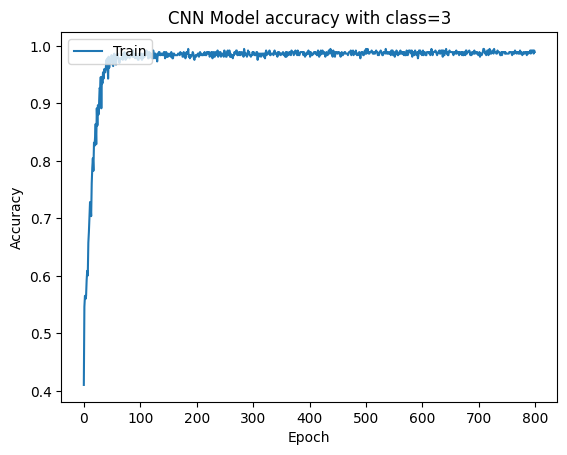

In [45]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

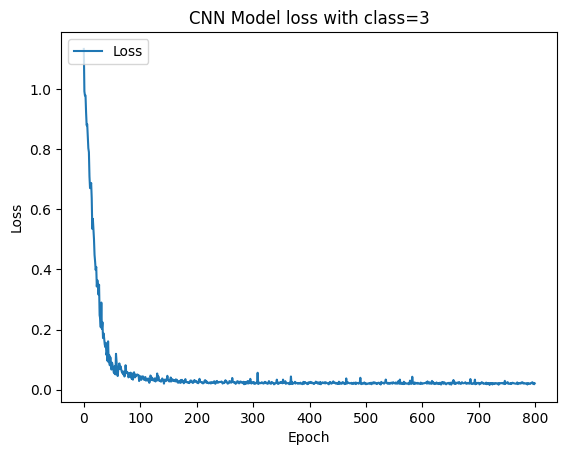

In [46]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()


In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [48]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 4ms/step
0.8064516129032258
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.80      0.91      0.85        43
           2       0.80      0.73      0.76        33

   micro avg       0.81      0.81      0.81        93
   macro avg       0.82      0.78      0.79        93
weighted avg       0.81      0.81      0.80        93
 samples avg       0.81      0.81      0.81        93

auc score:  0.8356360058210445


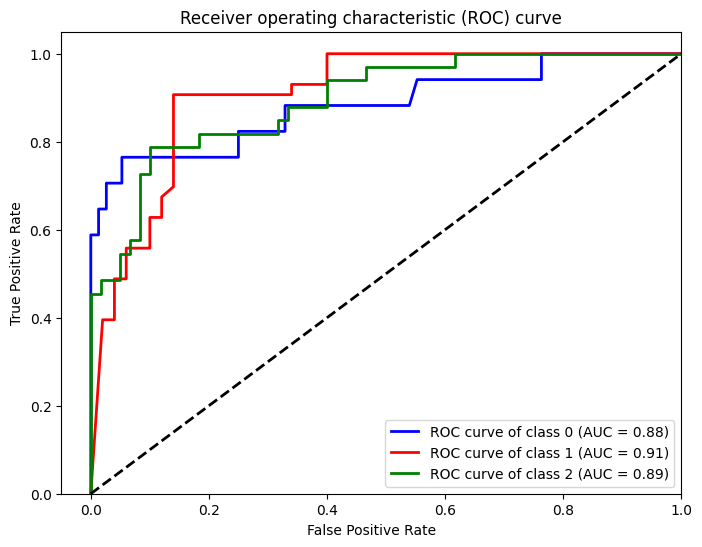

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


# 假设您已经有了预测结果y_valid_CNN和真实标签label_valid_y

# 将标签转换为二进制形式(假设是三分类问题)
y_valid_binary = label_binarize(label_valid_y, classes=[0, 1, 2])

# 计算每个类别的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binary[:, i], y_valid_CNN[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

## CNN2

In [30]:
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

def create_CNN_model():
    CNN = Sequential()
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True))

    CNN.add(Convolution1D(256, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(128, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(64, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Flatten())
    CNN.add(Dense(units = 512 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.3))
    CNN.add(Dense(units = 256 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.3))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    CNN.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return CNN


CNN_model = create_CNN_model()

# 创建ModelCheckpoint回调函数
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

class_weights = {0: 1.0, 1: 0.5, 2: 3.0}

start_time = time.time()

CNN_history = CNN_model.fit(feature_train, label_train_y,
                            epochs=800, batch_size=128,
                            validation_data=(feature_valid, label_valid_y),
                            class_weight=class_weights,
                            callbacks=[checkpoint])  # 将回调函数传递给fit函数


# 记录结束时间
end_time = time.time()

# 计算训练时间
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")
CNN_model.summary()

Epoch 1/800
3/3 [==============================] - ETA: 0s - loss: 8.0939 - accuracy: 0.3560
Epoch 1: val_accuracy improved from -inf to 0.35484, saving model to best_model.h5
3/3 [==============================] - 5s 502ms/step - loss: 8.0939 - accuracy: 0.3560 - val_loss: 7.8991 - val_accuracy: 0.3548
Epoch 2/800
1/3 [=========>....................] - ETA: 0s - loss: 7.8533 - accuracy: 0.4219

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 7.7257 - accuracy: 0.5027
Epoch 2: val_accuracy did not improve from 0.35484
3/3 [==============================] - 0s 129ms/step - loss: 7.7257 - accuracy: 0.5027 - val_loss: 7.8685 - val_accuracy: 0.3548
Epoch 3/800
3/3 [==============================] - ETA: 0s - loss: 7.5179 - accuracy: 0.5815
Epoch 3: val_accuracy did not improve from 0.35484
3/3 [==============================] - 0s 121ms/step - loss: 7.5179 - accuracy: 0.5815 - val_loss: 7.8116 - val_accuracy: 0.3548
Epoch 4/800
3/3 [==============================] - ETA: 0s - loss: 7.2981 - accuracy: 0.7364
Epoch 4: val_accuracy did not improve from 0.35484
3/3 [==============================] - 0s 123ms/step - loss: 7.2981 - accuracy: 0.7364 - val_loss: 7.7559 - val_accuracy: 0.3548
Epoch 5/800
3/3 [==============================] - ETA: 0s - loss: 7.0997 - accuracy: 0.7636
Epoch 5: val_accuracy did not improve from 0.35484
3/3 [==============================] - 0s 79ms/st

In [31]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 63ms/step
0.7634408602150538
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        17
           1       0.72      0.88      0.79        43
           2       0.76      0.67      0.71        33

   micro avg       0.76      0.76      0.76        93
   macro avg       0.83      0.73      0.76        93
weighted avg       0.78      0.76      0.76        93
 samples avg       0.76      0.76      0.76        93

auc score:  0.7967966256269948


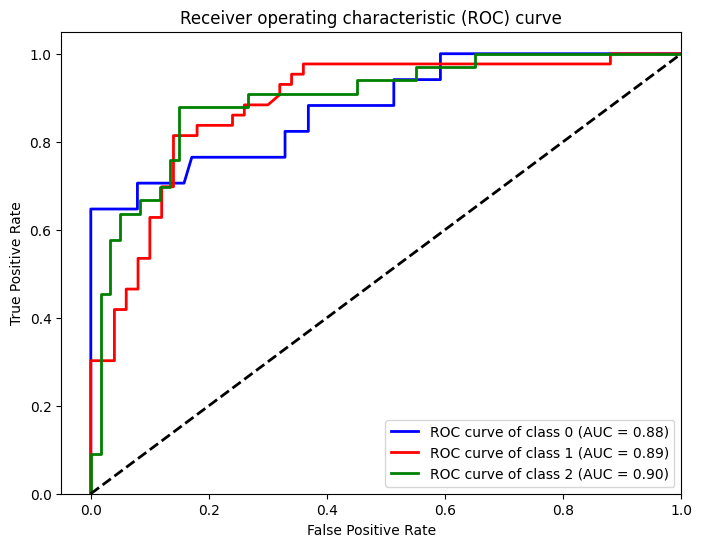

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


# 假设您已经有了预测结果y_valid_CNN和真实标签label_valid_y

# 将标签转换为二进制形式(假设是三分类问题)
y_valid_binary = label_binarize(label_valid_y, classes=[0, 1, 2])

# 计算每个类别的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binary[:, i], y_valid_CNN[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

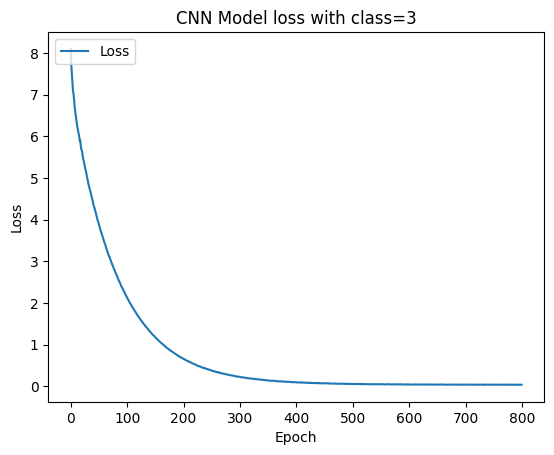

In [33]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

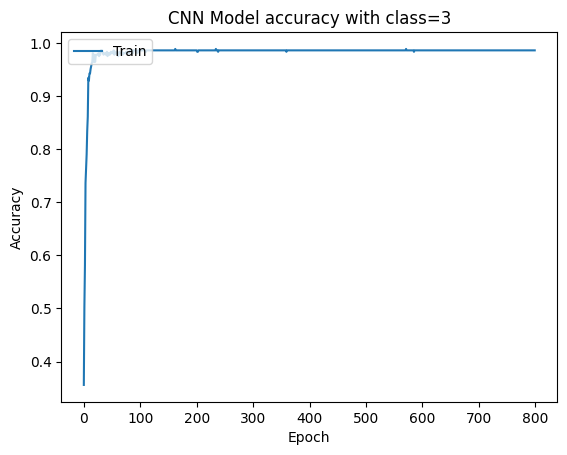

In [34]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

## RNN

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))
    RNN.add(Bidirectional(LSTM(word_dimension, return_sequences=True)))
    RNN.add(Dropout(0.2))
    RNN.add(Bidirectional(LSTM(word_dimension, return_sequences=True)))
    RNN.add(Dropout(0.2))
    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dropout(0.2))
    RNN.add(Dense(3, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return RNN

RNN_model = create_RNN_model()

# 创建 ModelCheckpoint 回调函数
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

start_time = time.time()

RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128, validation_data=(feature_valid, label_valid_y), callbacks=[checkpoint])

end_time = time.time()

print(f"Training time: {training_time:.2f} seconds")
RNN_model.summary()
# 加载最佳模型的权重
RNN_model.load_weights('best_model.h5')

Epoch 1/800
3/3 [==============================] - ETA: 0s - loss: 1.0322 - accuracy: 0.5435
Epoch 1: val_accuracy improved from -inf to 0.46237, saving model to best_model.h5
3/3 [==============================] - 13s 1s/step - loss: 1.0322 - accuracy: 0.5435 - val_loss: 1.0875 - val_accuracy: 0.4624
Epoch 2/800
1/3 [=========>....................] - ETA: 0s - loss: 1.0141 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.9977 - accuracy: 0.5543
Epoch 2: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 86ms/step - loss: 0.9977 - accuracy: 0.5543 - val_loss: 1.0359 - val_accuracy: 0.4624
Epoch 3/800
2/3 [===================>..........] - ETA: 0s - loss: 0.9839 - accuracy: 0.5508
Epoch 3: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 61ms/step - loss: 0.9838 - accuracy: 0.5543 - val_loss: 1.0426 - val_accuracy: 0.4624
Epoch 4/800
3/3 [==============================] - ETA: 0s - loss: 0.9794 - accuracy: 0.5543
Epoch 4: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 55ms/step - loss: 0.9794 - accuracy: 0.5543 - val_loss: 1.0501 - val_accuracy: 0.4624
Epoch 5/800
3/3 [==============================] - ETA: 0s - loss: 0.9655 - accuracy: 0.5543
Epoch 5: val_accuracy did not improve from 0.46237
3/3 [==============================] - 0s 56ms/step 

In [37]:
# validation with the RNN
y_valid_RNN = RNN_model.predict(feature_valid)
valid_y_RNN = y_valid_RNN.copy()
for i in range(len(y_valid_RNN)):
    j = np.where(y_valid_RNN[i] == np.amax(y_valid_RNN[i]))
    valid_y_RNN[i] = [0, 0, 0]
    valid_y_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_RNN))
print(classification_report(label_valid_y,valid_y_RNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_RNN))

3/3 [==============================] - 2s 19ms/step
0.7741935483870968
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.76      0.88      0.82        43
           2       0.76      0.67      0.71        33

   micro avg       0.77      0.77      0.77        93
   macro avg       0.79      0.75      0.77        93
weighted avg       0.78      0.77      0.77        93
 samples avg       0.77      0.77      0.77        93

auc score:  0.8122145822833419


## CNN+RNN

In [38]:
from keras.layers import Bidirectional, GRU, LSTM, Attention, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, Conv1D, MaxPooling1D
from keras.models import Model

def create_CNN_RNN_model():
    inputs = Input(shape=(maxlen,))
    embeddings = Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embeddings)
    pool1 = MaxPooling1D(3)(conv1)
    conv2 = Conv1D(128, 3, activation='relu')(pool1)
    pool2 = MaxPooling1D(3)(conv2)

    gru1 = Bidirectional(GRU(128, return_sequences=True))(pool2)
    gru2 = Bidirectional(GRU(64, return_sequences=True))(gru1)

    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(pool2)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)

    concat = Concatenate(axis=-1)([gru2, lstm2])

    attention = Attention()([concat, concat])

    pool = GlobalMaxPooling1D()(attention)

    dense1 = Dense(128, activation='relu')(pool)
    dropout1 = Dropout(0.5)(dense1)

    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)

    outputs = Dense(3, activation='softmax')(dropout2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model



In [39]:
CNN_RNN_model = create_CNN_RNN_model()
CNN_RNN_history = CNN_RNN_model.fit(feature_train, label_train_y, epochs=750, batch_size=128,validation_data=(feature_valid, label_valid_y))

Epoch 1/750
3/3 [==============================] - 17s 1s/step - loss: 1.0682 - accuracy: 0.4457 - val_loss: 1.0650 - val_accuracy: 0.4624
Epoch 2/750
3/3 [==============================] - 0s 38ms/step - loss: 1.0430 - accuracy: 0.5190 - val_loss: 1.0531 - val_accuracy: 0.4624
Epoch 3/750
3/3 [==============================] - 0s 37ms/step - loss: 1.0483 - accuracy: 0.5326 - val_loss: 1.0474 - val_accuracy: 0.4624
Epoch 4/750
3/3 [==============================] - 0s 37ms/step - loss: 1.0370 - accuracy: 0.5217 - val_loss: 1.0448 - val_accuracy: 0.4624
Epoch 5/750
3/3 [==============================] - 0s 34ms/step - loss: 1.0074 - accuracy: 0.5408 - val_loss: 1.0513 - val_accuracy: 0.4624
Epoch 6/750
3/3 [==============================] - 0s 34ms/step - loss: 1.0207 - accuracy: 0.5625 - val_loss: 1.0425 - val_accuracy: 0.4624
Epoch 7/750
3/3 [==============================] - 0s 36ms/step - loss: 1.0161 - accuracy: 0.5326 - val_loss: 1.0383 - val_accuracy: 0.4624
Epoch 8/750
3/3 [====

In [40]:
# validation with the RNN
y_valid_CNN_RNN = CNN_RNN_model.predict(feature_valid)
valid_y_CNN_RNN = y_valid_CNN_RNN.copy()
for i in range(len(y_valid_CNN_RNN)):
    j = np.where(y_valid_CNN_RNN[i] == np.amax(y_valid_CNN_RNN[i]))
    valid_y_CNN_RNN[i] = [0, 0, 0]
    valid_y_CNN_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_CNN_RNN))
print(classification_report(label_valid_y,valid_y_CNN_RNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN_RNN))

3/3 [==============================] - 2s 53ms/step
0.7204301075268817
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.73      0.86      0.79        43
           2       0.72      0.55      0.62        33

   micro avg       0.72      0.72      0.72        93
   macro avg       0.72      0.70      0.70        93
weighted avg       0.72      0.72      0.71        93
 samples avg       0.72      0.72      0.72        93

auc score:  0.7748909790539859


# 尝试下不用knowledgebase

## CNN1

In [41]:
X_train

410    Fund Summary\n\nFund/Class:\nFidelity® Emergin...
265    Ivy Core Equity Fund\n\nObjective\n\nTo seek t...
57     Fund Summary\n\nInvestment Objective\nThe fund...
199    SUMMARY OF COLUMBIA VP – LARGE CAP GROWTH FUND...
175    Janus Henderson International Opportunities Fu...
                             ...                        
106    Eaton Vance Global Small-Cap Fund\n\nIn connec...
270    Ivy Global Growth Fund\n\nObjective\n\nTo seek...
348    Franklin FTSE China ETF\n\nInvestment Goal\n\n...
435    INVESTMENT OBJECTIVE\nThe USAA Growth and Tax ...
102    Fund Summary\n\nInvestment Objective\n\nThe Fu...
Name: summary, Length: 368, dtype: object

In [42]:
feature_train

array([[ 44., 168.,  35., ..., 434., 237.,  87.],
       [378., 224.,  10., ..., 546.,  29., 109.],
       [228.,   2.,  10., ...,   8.,   8.,   1.],
       ...,
       [  2.,  43., 425., ..., 141.,  60., 176.],
       [101.,  83.,   9., ..., 236., 567.,  63.],
       [101.,  83.,   9., ...,   2., 129.,   3.]])

In [43]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# 加载预训练的BERT模型和分词器
bert_model_name = 'distilbert-base-uncased'  # 可以根据需要选择其他预训练的BERT模型
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# 定义函数将文本转换为BERT输入格式
def convert_text_to_bert_input(text):
    # 对文本进行分词
    tokens = tokenizer.tokenize(text)

    # 截断或补齐tokens到指定长度
    max_length = 512  # BERT的最大输入长度
    if len(tokens) > max_length - 2:
        tokens = tokens[:max_length - 2]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # 将tokens转换为对应的ID
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # 创建attention mask
    attention_mask = [1] * len(token_ids)

    # 补齐token_ids和attention_mask到指定长度
    padding_length = max_length - len(token_ids)
    token_ids += [0] * padding_length
    attention_mask += [0] * padding_length

    return token_ids, attention_mask

# 将X_train中的每个文本转换为BERT输入格式
bert_input = []
for text in X_train:
    token_ids, attention_mask = convert_text_to_bert_input(text)
    bert_input.append((token_ids, attention_mask))

# 将BERT输入转换为tensorflow Dataset
bert_input_dataset = tf.data.Dataset.from_generator(
    lambda: bert_input,
    output_types=(tf.int32, tf.int32),
    output_shapes=((None,), (None,))
)

# 使用BERT模型提取特征
feature_train = []
for token_ids, attention_mask in bert_input_dataset:
    token_ids = tf.reshape(token_ids, (1, -1))
    attention_mask = tf.reshape(attention_mask, (1, -1))
    outputs = bert_model(token_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    feature_train.append(pooled_output)

feature_train = tf.concat(feature_train, axis=0)

KeyboardInterrupt: 

In [ ]:
feature_train

In [ ]:
# 处理X_valid
bert_input_valid = []
for text in X_valid:
    token_ids, attention_mask = convert_text_to_bert_input(text)
    bert_input_valid.append((token_ids, attention_mask))

bert_input_valid_dataset = tf.data.Dataset.from_generator(
    lambda: bert_input_valid,
    output_types=(tf.int32, tf.int32),
    output_shapes=((None,), (None,))
)

feature_valid = []
for token_ids, attention_mask in bert_input_valid_dataset:
    token_ids = tf.reshape(token_ids, (1, -1))
    attention_mask = tf.reshape(attention_mask, (1, -1))
    outputs = bert_model(token_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    feature_valid.append(pooled_output)

feature_valid = tf.concat(feature_valid, axis=0)

# 处理X_test
bert_input_test = []
for text in X_test:
    token_ids, attention_mask = convert_text_to_bert_input(text)
    bert_input_test.append((token_ids, attention_mask))

bert_input_test_dataset = tf.data.Dataset.from_generator(
    lambda: bert_input_test,
    output_types=(tf.int32, tf.int32),
    output_shapes=((None,), (None,))
)

feature_test = []
for token_ids, attention_mask in bert_input_test_dataset:
    token_ids = tf.reshape(token_ids, (1, -1))
    attention_mask = tf.reshape(attention_mask, (1, -1))
    outputs = bert_model(token_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    feature_test.append(pooled_output)

feature_test = tf.concat(feature_test, axis=0)

In [ ]:
from tensorflow.keras.layers import Reshape

def create_CNN_model(bert_output_dim):
    CNN = Sequential()
    CNN.add(Reshape((bert_output_dim, 1), input_shape=(bert_output_dim,)))
    CNN.add(Convolution1D(64, 5, activation='relu'))
    CNN.add(MaxPooling1D(pool_size=5))
    CNN.add(Convolution1D(32, 5, activation='relu'))
    CNN.add(MaxPooling1D(pool_size=5))
    CNN.add(Flatten())
    CNN.add(Dense(units=128, activation='relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units=3, activation='softmax'))
    CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return CNN

bert_output_dim = feature_train.shape[1]  # 获取BERT特征的维度
CNN_model = create_CNN_model(bert_output_dim)
CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=100,
                            validation_data=(feature_valid, label_valid_y))

In [ ]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

## CNN2

In [ ]:
from keras.layers import BatchNormalization, Reshape
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

def create_CNN_model(bert_output_dim):
    CNN = Sequential()
    CNN.add(Reshape((bert_output_dim, 1), input_shape=(bert_output_dim,)))
    CNN.add(Convolution1D(256, 3, activation='relu', kernel_regularizer=l2(0.01)))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size=3))
    CNN.add(Convolution1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size=3))
    CNN.add(Convolution1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size=3))
    CNN.add(Flatten())
    CNN.add(Dense(units=512, activation='relu', kernel_regularizer=l2(0.02)))
    CNN.add(Dropout(0.4))
    CNN.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.02)))
    CNN.add(Dropout(0.4))
    CNN.add(Dense(units=3, activation='softmax'))

    opt = Adam(learning_rate=0.001)
    CNN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return CNN

bert_output_dim = feature_train.shape[1]  # 获取BERT特征的维度
CNN_model = create_CNN_model(bert_output_dim)

# 创建ModelCheckpoint回调函数
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
class_weights = {0: 1.0, 1: 0.5, 2: 2.0}

CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128,
                            validation_data=(feature_valid, label_valid_y),
                            class_weight=class_weights, callbacks=[checkpoint])

In [ ]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

# 直接用bert在下游训练一下然后做预测

In [ ]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight

# 加载微调的FinBERT模型和分词器
model_path = "mrm8488/finetuned-finbert-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 将文本转换为词汇表索引
def convert_examples_to_features(examples, max_seq_length):
    features = []
    for example in examples:
        tokens = tokenizer.tokenize(example)
        tokens = ['[CLS]'] + tokens[:max_seq_length - 2] + ['[SEP]']
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        features.append(input_ids)
    return tf.convert_to_tensor(features)

# 转换训练集和验证集
max_seq_length = 128
train_features = convert_examples_to_features(X_train, max_seq_length)
valid_features = convert_examples_to_features(X_valid, max_seq_length)

# 定义模型
model = TFAutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)

# 编译模型
optimizer = 'adam'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 计算类别权重
classes = np.unique(label_train_y)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=label_train_y)
class_weights = dict(zip(classes, class_weights))

# 训练模型
epochs = 50
batch_size = 32
history = model.fit(
    train_features,
    label_train_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(valid_features, label_valid_y),
    class_weight=class_weights
)

# 在验证集上进行预测
valid_predictions = model.predict(valid_features)
valid_predictions = tf.argmax(valid_predictions.logits, axis=1)

# 评估验证集上的性能
valid_acc = accuracy_score(label_valid_y, valid_predictions)
valid_f1 = f1_score(label_valid_y, valid_predictions, average='weighted')
print(f'Validation Accuracy: {valid_acc:.4f}')
print(f'Validation F1 (weighted): {valid_f1:.4f}')

# 打印分类报告
print('Classification Report:')
print(classification_report(label_valid_y, valid_predictions))

In [ ]:
label_valid_y